In [7]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
import nltk
from string import punctuation
from itertools import islice
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from afinn import Afinn
from textblob import TextBlob
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from pattern.en import lemma,lexeme
lem = nltk.WordNetLemmatizer()

In [2]:
df = pd.read_csv('Tweets.csv')

In [3]:
df.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


#### Text Preprocessing

In [4]:
def pos_tag_simplified(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def contractions(s):
    s = re.sub(r"won't", "will not",s)
    s = re.sub(r"would't", "would not",s)
    s = re.sub(r"could't", "could not",s)
    s = re.sub(r"\'d", " would",s)
    s = re.sub(r"can\'t", "can not",s)
    s = re.sub(r"n\'t", " not", s)
    s= re.sub(r"\'re", " are", s)
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\'t", " not", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\'m", " am", s)
    return s

In [ ]:
df['pre_process'] = df['Description'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))

df['pre_process'] = df['pre_process'].apply(lambda x:contractions(x))

df['pre_process'] = df['pre_process'].apply(lambda x: ' '.join([re.sub('[^A-z]+','',x) for x in nltk.word_tokenize(x)]))

df['pre_process'] = df['pre_process'].apply(lambda x: re.sub('Â |Â',' ',x))

df['pre_process'] = df['pre_process'].apply(lambda x: ' '.join(filter(lambda y: len(y) > 3, x.split())))

df['pre_process'] = df['pre_process'].apply(lambda x: re.sub('mm',' ',x))

df['pre_process'] = df['pre_process'].apply(lambda x: re.sub('cm',' ',x))

stop = nltk.corpus.stopwords.words('english')

df['pre_process'] = df['pre_process'].apply(lambda x: ' '.join([x for x in x.split() if x not in stop]))

tagged = nltk.pos_tag(df['pre_process'])

simple_tagged = list(map(lambda x:(x[0],pos_tag_simplified(x[1])),tagged))

lemmatized = [lem.lemmatize(i[0],i[1]) if i[1] != None else lem.lemmatize(i[0]) for i in simple_tagged]

df['pre_process'] = lemmatized

In [ ]:
df.head(3)

#### WordCloud

In [ ]:
txt = str(df['pre_process'].values)
wcd = WordCloud(max_font_size=100,background_color=None,stopwords='english').generate(txt)
plt.figure(figsize=(16,9))
plt.imshow(wcd,interpolation='gaussian')
plt.axis('off')
plt.show()

#### EDA

In [23]:
words = nltk.word_tokenize(str(df['pre_process'].values.tolist()))
words = [i.lower() for i in words if i.isalpha()]

In [25]:
freq = nltk.FreqDist(words)

In [26]:
df_freq = pd.DataFrame.from_dict([freq]).T
df_freq.columns=['words']

Text(0, 0.5, 'count of word')

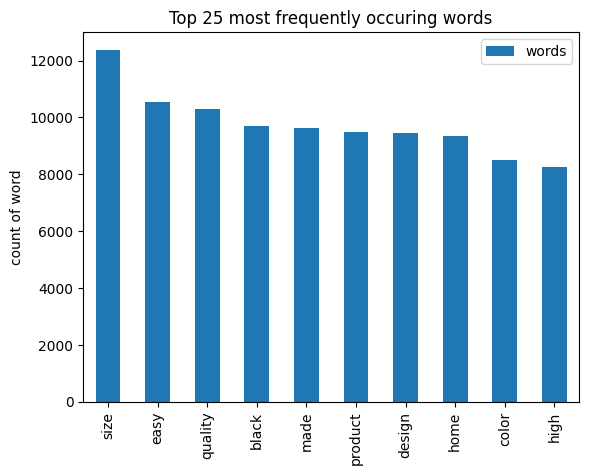

In [27]:
df_freq.sort_values(by='words',ascending=False)[:10]\
.plot(kind='bar',title='Top 25 most frequently occuring words')
plt.ylabel('count of word')

<Axes: xlabel='Product Category', ylabel='count'>

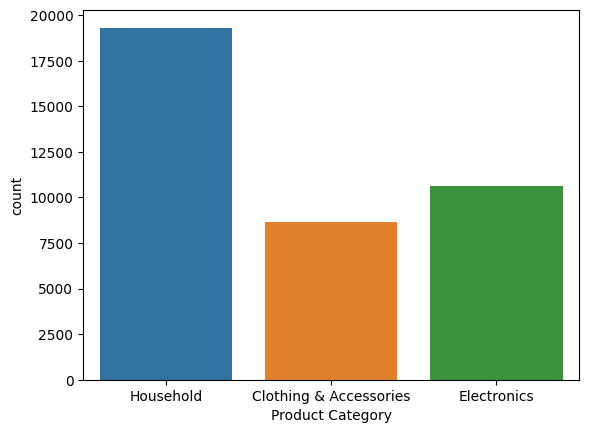

In [28]:
sns.countplot(x=df['Product Category'])

In [29]:
df['word_count'] = df['pre_process'].apply(lambda x: len(str(x).split()))

In [30]:
print('The average number of words in product description of Electronics is: {}'.format(round(df[df['Product Category'] == 'Electronics']['word_count'].mean())))

The average number of words in product description of Electronics is: 77


In [31]:
print('The average number of words in product description of Household is: {}'.format(round(df[df['Product Category'] == 'Household']['word_count'].mean())))

The average number of words in product description of Household is: 64


In [32]:
print('The average number of words in product description of Clothing & Accessories is: {}'.format(round(df[df['Product Category'] == 'Clothing & Accessories']['word_count'].mean())))

The average number of words in product description of Clothing & Accessories is: 44


#### Tf-Idf

In [36]:
vec = TfidfVectorizer(use_idf=True)

In [37]:
x_train = vec.fit_transform(x_train)
x_test = vec.transform(x_test)

#### Text Classification

##### SVM Model

In [38]:
model_svm = LinearSVC(random_state=0)

In [39]:
model_svm.fit(x_train,y_train)

LinearSVC(random_state=0)

In [40]:
pred_svm = model_svm.predict(x_test)

In [41]:
report_svm = classification_report(y_test,pred_svm)

In [42]:
print(report_svm)

                        precision    recall  f1-score   support

Clothing & Accessories       0.99      0.98      0.99      2074
           Electronics       0.98      0.98      0.98      2676
             Household       0.98      0.99      0.99      4902

              accuracy                           0.98      9652
             macro avg       0.99      0.98      0.98      9652
          weighted avg       0.98      0.98      0.98      9652



##### Logistic Regression

In [43]:
model_log = LogisticRegression(max_iter=2000)

In [44]:
model_log.fit(x_train,y_train)

LogisticRegression(max_iter=2000)

In [45]:
pred_log = model_log.predict(x_test)

In [46]:
report_log = classification_report(y_test,pred_log)

In [47]:
print(report_log)

                        precision    recall  f1-score   support

Clothing & Accessories       0.99      0.97      0.98      2074
           Electronics       0.98      0.96      0.97      2676
             Household       0.97      0.99      0.98      4902

              accuracy                           0.98      9652
             macro avg       0.98      0.97      0.98      9652
          weighted avg       0.98      0.98      0.98      9652



#### Text Clustering

In [48]:
x = vec.transform(df['pre_process'])

In [49]:
wcss = []
for i in range(1,5):
    clustering = KMeans(n_clusters=i,init='k-means++',random_state=42)
    clustering.fit(x)
    wcss.append(clustering.inertia_)
ks = [1,2,3,4]

<Axes: >

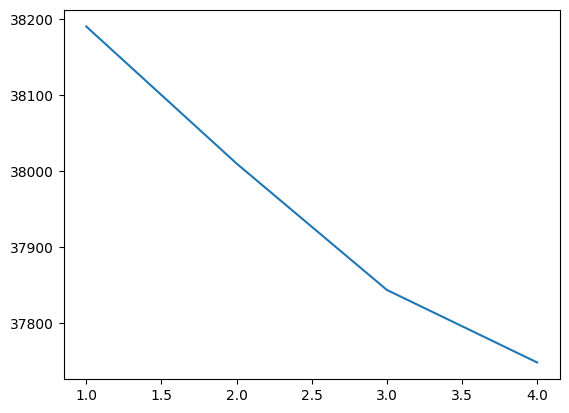

In [50]:
sns.lineplot(x=ks,y=wcss)

In [51]:
model = KMeans(n_clusters=3,init='k-means++',max_iter=100,n_init=1)
model.fit(x)

KMeans(max_iter=100, n_clusters=3, n_init=1)

In [52]:
print('Top 10 terms per cluster:')
order_centroids = model.cluster_centers_.argsort()[:,::-1]
terms = vec.get_feature_names_out()
for i in range(3):
    print('Cluster %d:'%i)
    for ind in order_centroids[i,:10]:
        print(' %s '%terms[ind])
    print('\n')

Top 10 terms per cluster:
Cluster 0:
 steel 
 home 
 easy 
 black 
 stainless 
 table 
 color 
 size 
 quality 
 product 


Cluster 1:
 cotton 
 women 
 wear 
 fabric 
 girls 
 boys 
 made 
 soft 
 look 
 pack 


Cluster 2:
 bluetooth 
 cable 
 audio 
 wireless 
 camera 
 speaker 
 card 
 music 
 power 
 black 




In [53]:
def cluster_tag(txt):
    de = vec.transform([txt])
    return model.predict(de)[0]

In [54]:
df['clusters'] = df['pre_process'].apply(lambda x: cluster_tag(x))

Checking the top 10 words in every cluster, we can say that:
- Cluster 0 contains all Household products
- Cluster 1 contains all Clothing and Accessories products
- Cluster 2 contains all Electronics

#### Topic Modelling

In [85]:
dict_ = gensim.corpora.Dictionary(df['pre_process'].str.split())

In [86]:
list(islice(dict_.iteritems(), 5))

[(0, 'achieve'),
 (1, 'apart'),
 (2, 'attracts'),
 (3, 'beautiful'),
 (4, 'blissso')]

In [95]:
corpus = [dict_.doc2bow(i) for i in df['pre_process'].str.split()]

In [96]:
tf = gensim.models.TfidfModel(corpus)

In [97]:
tf_corpus = tf[corpus]

In [100]:
model_lda = gensim.models.LdaMulticore(tf_corpus,num_topics=3,id2word=dict_,workers=5,passes=5)

In [101]:
for idx, topic in model_lda.print_topics(-1):
    print('Topic: {}:\t Word: {}'.format(idx,topic))

Topic: 0:	 Word: 0.004*"bluetooth" + 0.003*"audio" + 0.003*"cable" + 0.003*"wireless" + 0.003*"speaker" + 0.003*"camera" + 0.003*"music" + 0.003*"sound" + 0.002*"black" + 0.002*"power"
Topic: 1:	 Word: 0.002*"cotton" + 0.002*"light" + 0.002*"table" + 0.002*"home" + 0.001*"color" + 0.001*"size" + 0.001*"made" + 0.001*"design" + 0.001*"water" + 0.001*"easy"
Topic: 2:	 Word: 0.003*"cotton" + 0.003*"women" + 0.002*"wear" + 0.002*"size" + 0.002*"black" + 0.002*"amazonbasics" + 0.002*"steel" + 0.002*"fabric" + 0.002*"shirt" + 0.002*"maternity"


We can say that
- Topic 0 is Electronics, Cluster 2
- Topic 1 is Household products, Cluster 0
- Topic 2 is Clothing and Accessories, Cluster 1

#### Sentiment Analysis Lexicons approach

##### Afinn

In [7]:
afn = Afinn()

In [9]:
# Creating list sentences
news_df = ["les gens pensent aux chiens","I hate flowers","hes kind and smart","we are kind to good people"]

In [4]:
news_df[1]

'I hate flowers'

In [13]:
afn.score(news_df[1])

-3.0

In [16]:
scores = [afn.score(article) for article in news_df]
sentiment = ["positive" if score >0 else 'negative' if score < 0 else "neutral" for score in scores]
print(sentiment)

['neutral', 'negative', 'positive', 'positive']


In [17]:
## Dataframe creation
df = pd.DataFrame()
df["topic"] = news_df
df["scores"] = scores
df["sentiments"] = sentiment

In [18]:
df.head()

,topic,scores,sentiments
0,les gens pensent aux chiens,0.0,neutral
1,I hate flowers,-3.0,negative
2,hes kind and smart,3.0,positive
3,we are kind to good people,5.0,positive


##### TextBlob

In [35]:
sentence1 = "everest is the highest mountain in the world"

In [43]:
s1 = TextBlob(news_df[3])
s1

TextBlob("we are kind to good people")

In [44]:
print(s1.polarity)
print(s1.subjectivity)

0.6499999999999999
0.75


In [90]:
tweets_df= pd.read_csv("Tweets.csv")

In [91]:
tweets_df["sentiment_score"] = tweets_df["text"].apply(afn.score)

In [92]:
tweets_df["sentiment"] = np.where(tweets_df["sentiment_score"]>0,"positive",np.where(tweets_df["sentiment_score"]<0,"negative","neutral"))

In [93]:
tweets_df["polarity_score"] = tweets_df["text"].apply(lambda x : TextBlob(x).polarity)

In [94]:
tweets_df["subjectivity_score"] = tweets_df["text"].apply(lambda x : TextBlob(x).subjectivity)

In [95]:
tweets_df["sentiment_textblob"] = tweets_df["text"].apply(lambda x :  TextBlob(x).sentiment[1])

In [96]:
tweets_df["textblob_Sentiment"] = np.where(tweets_df["sentiment_textblob"]>0,"positive",np.where(tweets_df["sentiment_textblob"]<0,"negative","neutral"))

In [98]:
tweets_df = tweets_df.loc[:,["text","sentiment","sentiment_score","polarity_score","subjectivity_score","textblob_Sentiment"]]

In [99]:
tweets_df.head()

,text,sentiment,sentiment_score,polarity_score,subjectivity_score,textblob_Sentiment
0,@VirginAmerica What @dhepburn said.,neutral,0.0,0.000000,0.000000,neutral
1,@VirginAmerica plus you've added commercials t...,neutral,0.0,0.000000,0.000000,neutral
2,@VirginAmerica I didn't today... Must mean I n...,neutral,0.0,-0.390625,0.687500,positive
3,@VirginAmerica it's really aggressive to blast...,negative,-5.0,0.006250,0.350000,positive
4,@VirginAmerica and it's a really big bad thing...,negative,-2.0,-0.350000,0.383333,positive


#### Text Similarity

In [8]:
sent1 = "The bottle is empty"
sent2  = "There is nothing in the bottle"

In [9]:
def get_jaccard_sim(str1,str2):
    a = set(str1.split())
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [10]:
a = set(sent1.split())
b = set(sent2.split())
c = a.intersection(b)
c

{'bottle', 'is'}

In [11]:
get_jaccard_sim(sent1,sent2)

0.25

In [14]:
def get_cosine_sim(*strs):
    vectors = [t for t in get_vectors(*strs)]
    return cosine_similarity(vectors)

def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer()
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

In [15]:
get_cosine_sim(sent1,sent2,"water bottle")

array([[1.        , 0.61237244, 0.35355339],
       [0.61237244, 1.        , 0.28867513],
       [0.35355339, 0.28867513, 1.        ]])

#### Synsets

In [89]:
sys = wordnet.synsets("Book")

In [90]:
for i in sys:
    print(i.name())

book.n.01
book.n.02
record.n.05
script.n.01
ledger.n.01
book.n.06
book.n.07
koran.n.01
bible.n.01
book.n.10
book.n.11
book.v.01
reserve.v.04
book.v.03
book.v.04


In [14]:
wordnet.synsets("Book")[13].definition()

'record a charge in a police register'

In [53]:
wordnet.synsets("run")[1]

Synset('test.n.05')

In [15]:
wordnet.synsets("run")[0].definition()

'a score in baseball made by a runner touching all four bases safely'

In [30]:
syn = wordnet.synsets("run")[23]

In [31]:
print(f"Synset name : {syn.name()}\nSynset definition : {syn.definition()}\nExamples : {syn.examples()}")

Synset name : range.v.01
Synset definition : change or be different within limits
Examples : ['Estimates for the losses in the earthquake range as high as $2 billion', 'Interest rates run from 5 to 10 percent', 'The instruments ranged from tuba to cymbals', 'My students range from very bright to dull']


#### Hypernym and Hyponym

In [16]:
syn = wordnet.synsets("table")[1]

In [19]:
print(f'''Synset name : {syn.name()}\n\nSynset abstract term: {syn.hypernyms()}
\n\nHyponyms : {syn.hyponyms()}\n\nSynset specific term : {syn.hypernyms()[0].hyponyms()} \
\n\nSynset root hypernym : {syn.root_hypernyms()}''')

Synset name : table.n.02

Synset abstract term: [Synset('furniture.n.01')]


Hyponyms : [Synset('altar.n.01'), Synset('booth.n.01'), Synset('breakfast_table.n.01'), Synset('card_table.n.01'), Synset('card_table.n.02'), Synset('coffee_table.n.01'), Synset('conference_table.n.01'), Synset('console_table.n.01'), Synset('counter.n.01'), Synset('desk.n.01'), Synset('dressing_table.n.01'), Synset('drop-leaf_table.n.01'), Synset('gaming_table.n.01'), Synset('gueridon.n.01'), Synset('kitchen_table.n.01'), Synset('operating_table.n.01'), Synset('parsons_table.n.01'), Synset('pedestal_table.n.01'), Synset('pier_table.n.01'), Synset('platen.n.01'), Synset('pool_table.n.01'), Synset('stand.n.04'), Synset('table-tennis_table.n.01'), Synset('tea_table.n.01'), Synset('trestle_table.n.01'), Synset('worktable.n.01')]

Synset specific term : [Synset('baby_bed.n.01'), Synset('bedroom_furniture.n.01'), Synset('bedstead.n.01'), Synset('bookcase.n.01'), Synset('buffet.n.01'), Synset('cabinet.n.01'), Synset(

In [20]:
def get_synset(w):
    syn = wordnet.synsets(w)
    s =[i.name() for i in syn]
    s1 = [i.definition() for i in syn]
    s2 = [i.examples() for i in syn]
    d1 = {"Word":w}
    d2 = {w: [i.name() for i in syn]}
    d3 = {k : v for k,v in zip(s,s1)}
    d4 = {w: e for w,e in zip(s,s2)}
    
    return [d1 ,d2,d3,d4]

In [21]:
get_synset("banana")

[{'Word': 'banana'},
 {'banana': ['banana.n.01', 'banana.n.02']},
 {'banana.n.01': 'any of several tropical and subtropical treelike herbs of the genus Musa having a terminal crown of large entire leaves and usually bearing hanging clusters of elongated fruits',
  'banana.n.02': 'elongated crescent-shaped yellow fruit with soft sweet flesh'},
 {'banana.n.01': [], 'banana.n.02': []}]

#### Wu-Palmer and Path Length based

In [22]:
syn1 = wordnet.synsets('apple')[0]
syn2 = wordnet.synsets('banana')[0]


In [23]:
print("Path similarity: ",syn1.path_similarity(syn2))
print("Wu palmer similarity : ",syn1.wup_similarity(syn2))

Path similarity:  0.07142857142857142
Wu palmer similarity :  0.38095238095238093


In [24]:
synonyms = []
antonyms = []

for syn in wordnet.synsets("positive"):
    for i in syn.lemmas():
        synonyms.append(i.name())
        if i.antonyms():
            antonyms.append(i.antonyms()[0].name())
            
print(set(synonyms))
print("\n")
print(set(antonyms))

{'positivist', 'irrefutable', 'positively_charged', 'confirming', 'positivistic', 'cocksure', 'prescribed', 'electropositive', 'overconfident', 'positive', 'confident', 'positive_degree', 'incontrovertible', 'convinced', 'plus'}


{'negative'}


In [25]:
tree = wordnet.synsets("atom")[0]

In [26]:
tree.part_holonyms()

[Synset('chemical_element.n.01'), Synset('molecule.n.01')]

In [27]:
tree.part_meronyms()

[Synset('elementary_particle.n.01'), Synset('nucleus.n.02')]

#### Pattern Lemmatizer

In [ ]:
lemma("watching")

['play', 'plays', 'playing', 'played']

In [ ]:
lexeme("play")

In [ ]:
sentence = "The striped bats were hanging on their feet and ate best fishes"

In [ ]:
## Lemma for each word
[lemma(wd) for wd in sentence.split()]

['the',
 'stripe',
 'bat',
 'be',
 'hang',
 'on',
 'their',
 'feet',
 'and',
 'eat',
 'best',
 'fishes']

In [ ]:
lexeme("saw")

['see', 'sees', 'seeing', 'saw', 'seen']

In [ ]:
## lexeme's for each word
[lexeme(word) for word in sentence.split()]

[['the', 'thes', 'thing', 'thed'],
 ['stripe', 'stripes', 'striping', 'striped'],
 ['bat', 'bats', 'batting', 'batted'],
 ['be',
  'am',
  'are',
  'is',
  'being',
  'was',
  'were',
  'been',
  'am not',
  "aren't",
  "isn't",
  "wasn't",
  "weren't"],
 ['hang', 'hangs', 'hanging', 'hung'],
 ['on', 'ons', 'oning', 'oned'],
 ['their', 'theirs', 'theiring', 'theired'],
 ['feet', 'feets', 'feeting', 'feeted'],
 ['and', 'ands', 'anding', 'anded'],
 ['eat', 'eats', 'eating', 'ate', 'eaten'],
 ['best', 'bests', 'besting', 'bested'],
 ['fishes', 'fishing', 'fishesed']]

#### TextBlob Lemmatizer

In [ ]:
## define function to lemmatize each word with its POS tag
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict  = {
    "J" : "a",
    "N" : "n",
    "V" : 'v',
    "R" : "r"}
    words_and_tags = [(w,tag_dict.get(pos[0],"n")) for w , pos in sent.tags]
    lemmatized_list = [wd.lemmatize(tag) for wd,tag in rds_and_tags]
    return " ".join(lemmatized_list)

#### Stemming

##### Porter Stemmer

In [ ]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
  
ps = PorterStemmer()
  
# choose some words to be stemmed
words = ["program", "programs", "programmer", "programming", "programmers"]
  
for w in words:
    print(w, " : ", ps.stem(w))
    
sentence = "Programmers program with programming languages"
words = word_tokenize(sentence)
  
for w in words:
    print(w, " : ", ps.stem(w))

##### SnowBall Stemmer

In [ ]:
from nltk.stem import SnowballStemmer
snowball = SnowballStemmer(language='english')
words = ['generous','generate','generously','generation']
for word in words:
    print(word,"--->",snowball.stem(word))

##### Lancaster Stemmer

In [ ]:
from nltk.stem import LancasterStemmer
lancaster = LancasterStemmer()
words = ['eating','eats','eaten','puts','putting']
for word in words:
    print(word,"--->",lancaster.stem(word))

##### RegExp Stemmer

In [ ]:
from nltk.stem import RegexpStemmer
regexp = RegexpStemmer('ing$|s$|e$|able$', min=4)
words = ['mass','was','bee','computer','advisable']
for word in words:
    print(word,"--->",regexp.stem(word))